## Purpose for this notebook: Learn from the professional user in kaggle

#### Once you have understand the theory of data science, it is not easy for you to apply it on a real-world problem
#### Kaggle got many experts and they did it very well. This notebook is aimed to demostrate how they work on the EDA
#### about the house price data set. I just follow how the editor(DOMINIK GAWLIK) analyse the data step by step and 
#### add some code for me to understand more why they will do it.
#### It is a good chance to understand more about how I can apply what I have learnt.
--------------------------------------------------------------------------------------------------------
#### Data set used: House Pirce

#### Reference: https://www.kaggle.com/dgawlik/house-prices-eda/notebook

In [1]:
# simple setting for background

%matplotlib inline
import numpy as np
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import warnings # Hide the warning for sns.distplot
warnings.filterwarnings('ignore') # Not suggest since it may ignore critical warning

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Checking for missing column by compariing training and testing set

def check_duplicate_column(train, test):
    return train.columns[train.columns.isin(test.columns) == False]

In [3]:
# Read the data
test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')

In [4]:
check_duplicate_column(train, test)

Index(['SalePrice'], dtype='object')

#### First Step: Classify the type for each columns

In [5]:
# Classify the quantitative and qualitative columns
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('Id') # Remove the columns that's not estiential
quantitative.remove('SalePrice') # Remove the target
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

#### Second Step: Determine the missing number for each features

<AxesSubplot:>

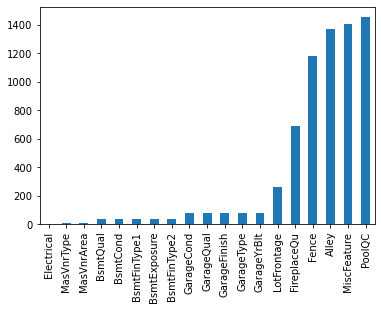

In [6]:
# Showing that 19 attributes have missing values
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar()

Show that 19 attributes got missing value and we have to consider how to fill it up such as
classifying it as missing in their catergorials or tried it drop it out but those important information
will be lost. Also, using one-hot encoding will generate more column/ dimension and it is not good
for having the prediction model since it will increase the chance for overfiting

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

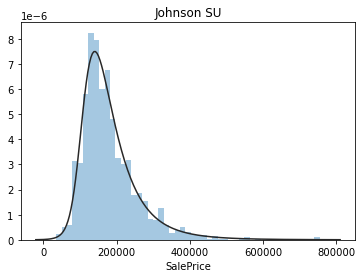

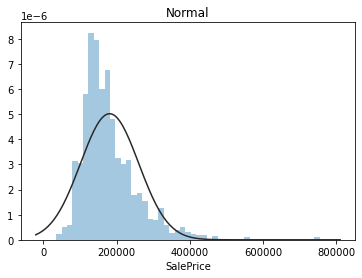

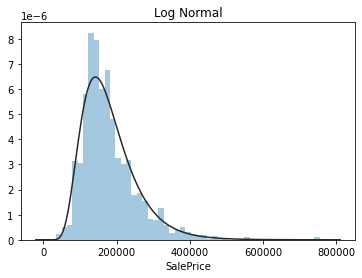

In [7]:
# Determine the distribution by using the visualization of histogram and line plot

import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde = False, fit = st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde = False, fit = st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde = False, fit = st.lognorm)

To determine the distribution for SalePrice, distplot was used to compare the line and histogram. From the graph, we know that the data is not fit by using normal distribution. We can see that it is fit for log normal distribution and it is perfectly fit to johnson distribution.

In [8]:
# Check all the quantitative variables has normal distribution or not
test_normality = lambda x: st.shapiro(x.fillna(0))[1] < 0.01 # checking with the p-value
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


Also, none of the quantitative variables has normal distribution by using the shapiro function. Therefore, the data needed to be transformed.

The stats.shapiro() function is testing the data set. The H0 (null hypothesis) will be the data was drawn from normal distribution.

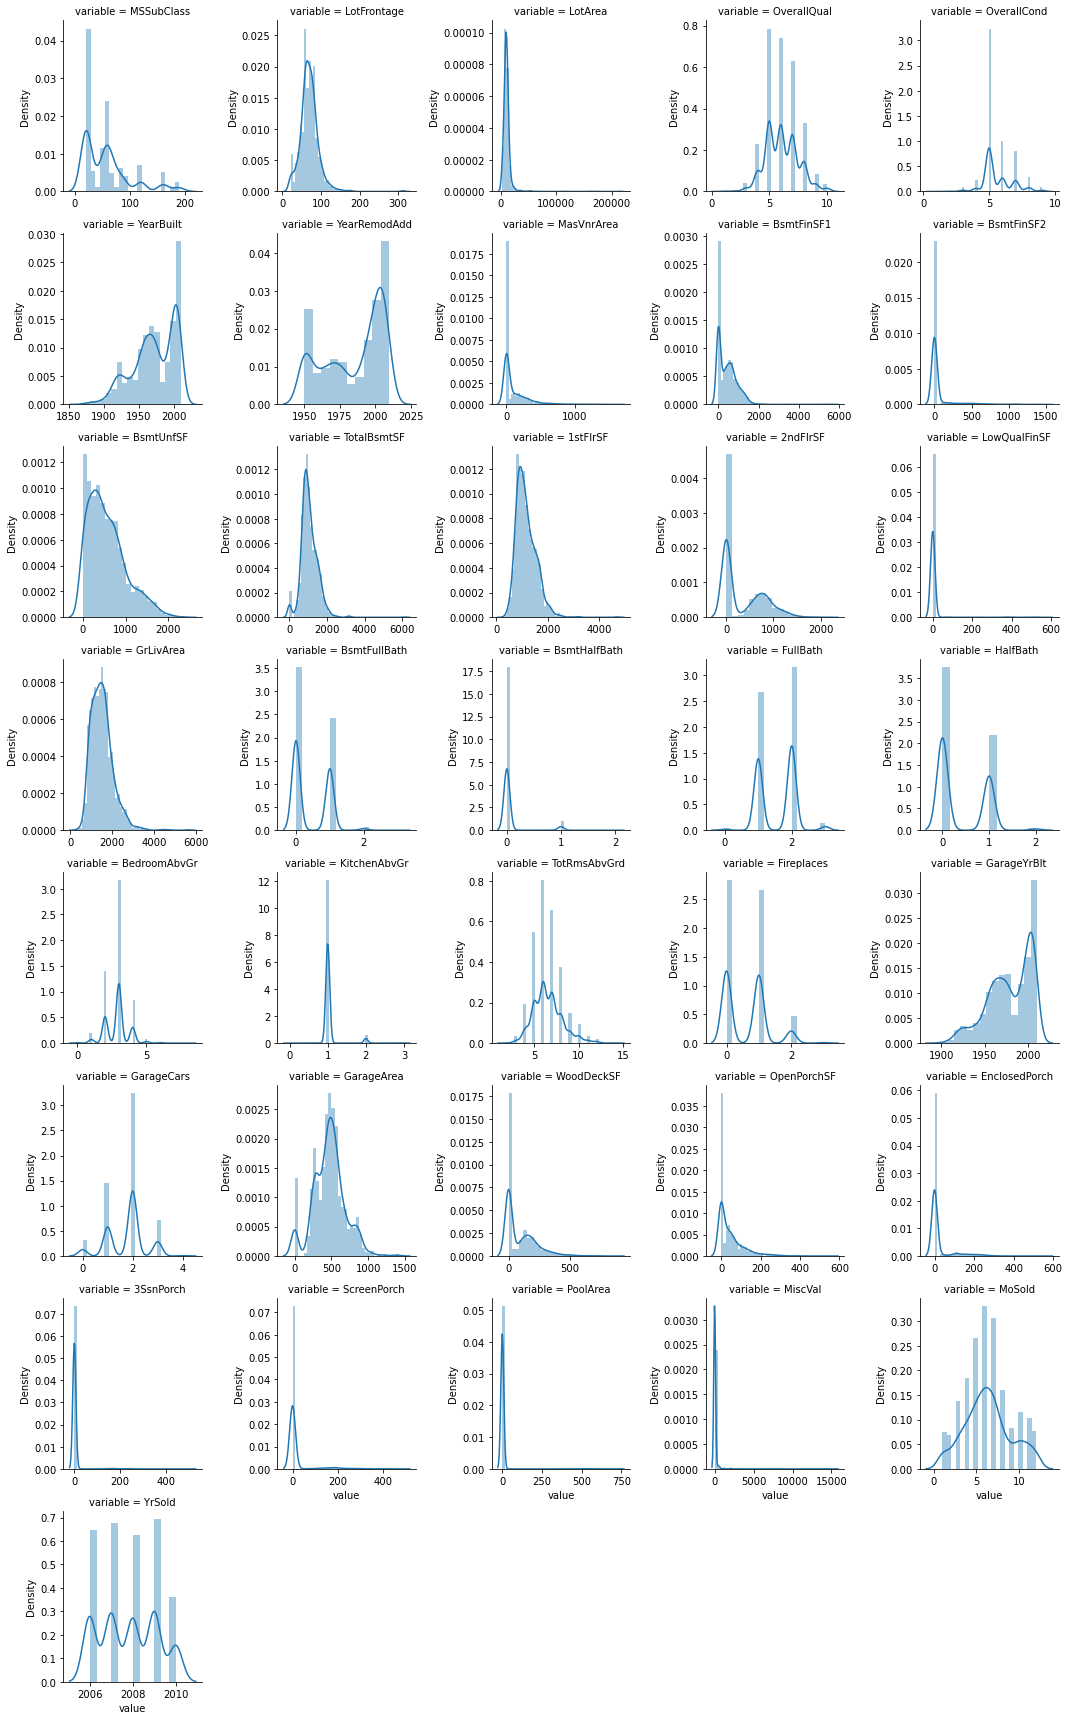

In [9]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

According to the editor, these variable: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea is good for using the log transformation. 

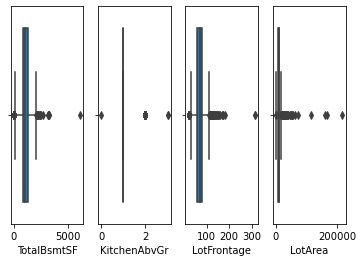

In [10]:
variable_for_checking = ['TotalBsmtSF', 'KitchenAbvGr', 'LotFrontage', 'LotArea']
for i, v in enumerate(variable_for_checking):
    plt.subplot(1,4,i+1)
    sns.boxplot(train[v])

By checking the data in these variables, boxplot was used and some outlier was observed.
To eliminate the effect from outlier, the log transformation can help to minimize the effect and give a better distribution for further analysis/ model training

After checking the quantitative variables, quanlitative variables will be visualized by using the boxplot
and comparing with target quantitative variables.

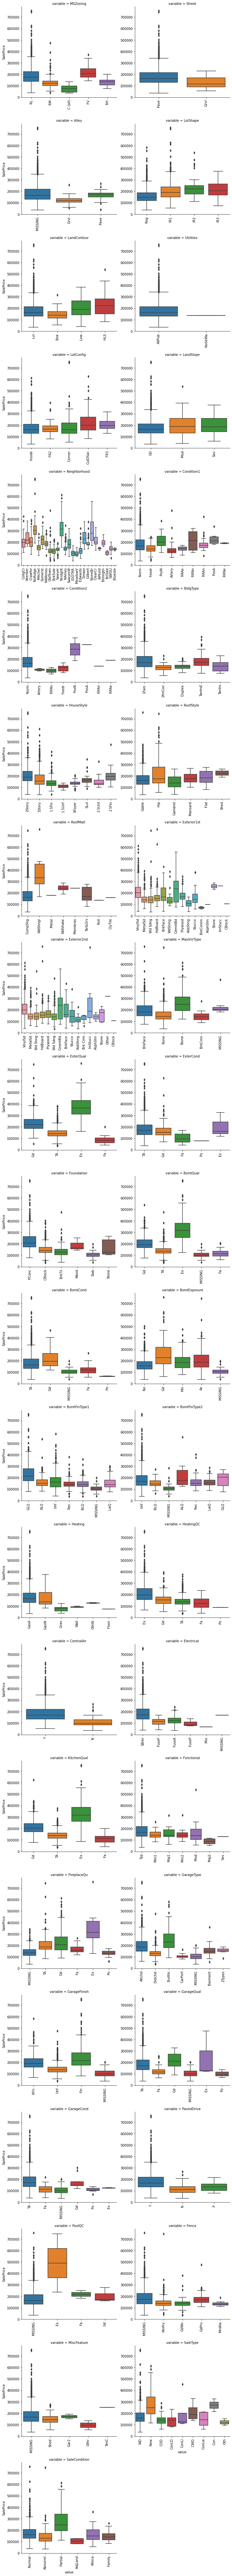

In [11]:
# Create the missing value for some qualitative variables
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')
        
def boxplot(x, y, **kwargs):
    sns.boxplot(x = x, y = y)
    x=plt.xticks(rotation = 90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex= False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'SalePrice')

Some categories is more diverse with respect to SalePrice than others. Neighbourhood got a great impact towards the SalePrice. Also, pool will be critical for high price. Partial SaleCondition will be most expensive.

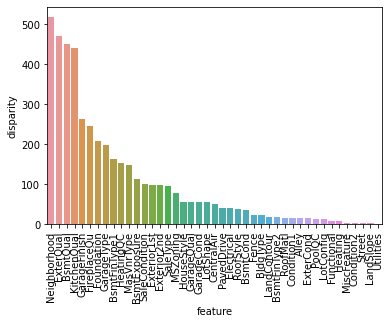

In [12]:
# Define the anova function and check with the train data
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x = 'feature', y = 'disparity')
x=plt.xticks(rotation=90)

Just a quick estimation of influence of categorical variable on SalePrice. ANOVA was used to detemine is there any difference or same distribution between group mean with f-test. Therefore, stats.f_oneway was used for ANOVA testing (analysis of variance). If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing  diversity in partitions.

In [13]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
        
qual_encoded = []
for q in qualitative:
    encode(train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


Now qualitative variables get encoded according to ordering based on mean of SalePrice. We can check that the variable was encoded will generate the column in dataset and changed to rank/ numeric value. It helps to provide more information for the model that we are going to apply.

In [14]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,1,60,RL,65.0,8450,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
1,2,20,RL,80.0,9600,Pave,MISSING,Reg,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
2,3,60,RL,68.0,11250,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0
3,4,70,RL,60.0,9550,Pave,MISSING,IR1,Lvl,AllPub,...,3.0,2.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,2.0
4,5,60,RL,84.0,14260,Pave,MISSING,IR1,Lvl,AllPub,...,6.0,3.0,4.0,6.0,3.0,1.0,5.0,4.0,5.0,5.0


### Correlations

In this section, spearman's rank correlation was used.

It said that the variable that uncorrelated to each other but correlated with SalePrice should be added to the regression model to reduce the confunding.

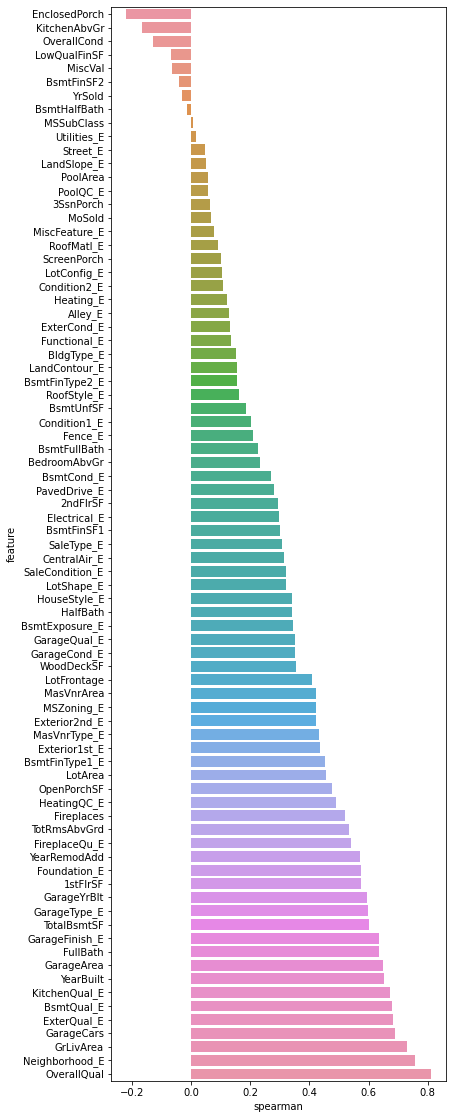

In [15]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize = (6, .25 * len(features)))
    sns.barplot(data = spr, y = 'feature', x = 'spearman', orient = 'h')
    
features = quantitative + qual_encoded
spearman(train, features)

Spearman correlation was used since it also pick up the relationsips between variables even they are nonlinear. By taking look for the plot, the OverallQual will be the major criteria towards the house price. 

<AxesSubplot:>

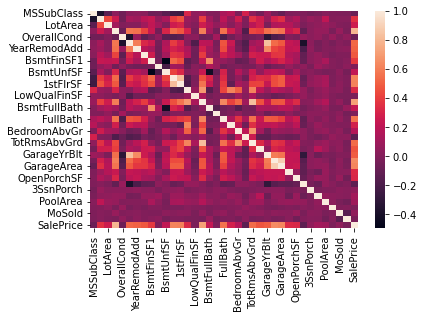

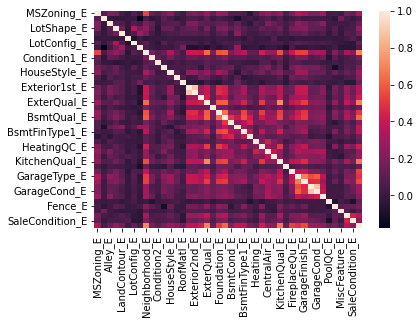

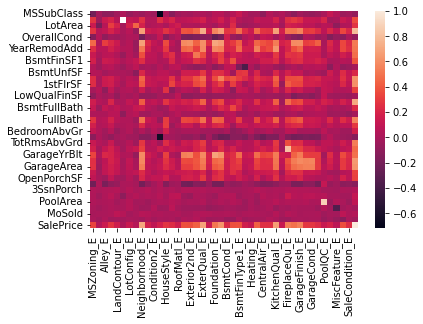

In [16]:
# Focusing on the correlation of all parameters towards the House Sale Price
# Work on the first graph in plt figure
plt.figure(1)
# DataFrame correlation can be calculated by using the corr function
# Showing the correlation of quantitative value
corr = train[quantitative + ['SalePrice']].corr()
# Put the corr table for seaborn to generate a heat map for visualization
sns.heatmap(corr)
# Work on the second graph in plt figure
plt.figure(2)
# Showing the corrleation of encoded qualitative value
corr = train[qual_encoded +['SalePrice']].corr()
sns.heatmap(corr)
# Work on the third graph in plt figure
plt.figure(3)
# Showing the correlation of quanlitative and quantitative value
# Create a data frame with quantitative value as index/ row and encoded qualitative value as column
corr = pd.DataFrame(np.zeros([len(quantitative)+1, len(qual_encoded) + 1]), index = quantitative + ['SalePrice'], columns = qual_encoded + ['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        # Assign the coresponding location for the correation for those values
        # Get rid of some information that's replicate from the previous two graph
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

It's hard to take a look on the heatmap and the style of the heatmap needed to be changed to have a better observation.

Try to get rid of the red color and we can observe some strong relation for the white and black color. For the Garage area was corrlated to the build year. Also, the basement unit and the first floor was also correlated.

From the thrid graph, there is a pink stragint in the neighborhood and that's mean it is correlated to many different variables.

##### Pairplot

From Kaggle editor, it is the part to see how sale price compares to each independent variable. We may observe some pattern that we can apply the quadratic term to regression. Also, some nonlinearties variable will not be selected by Lasso/Lars.

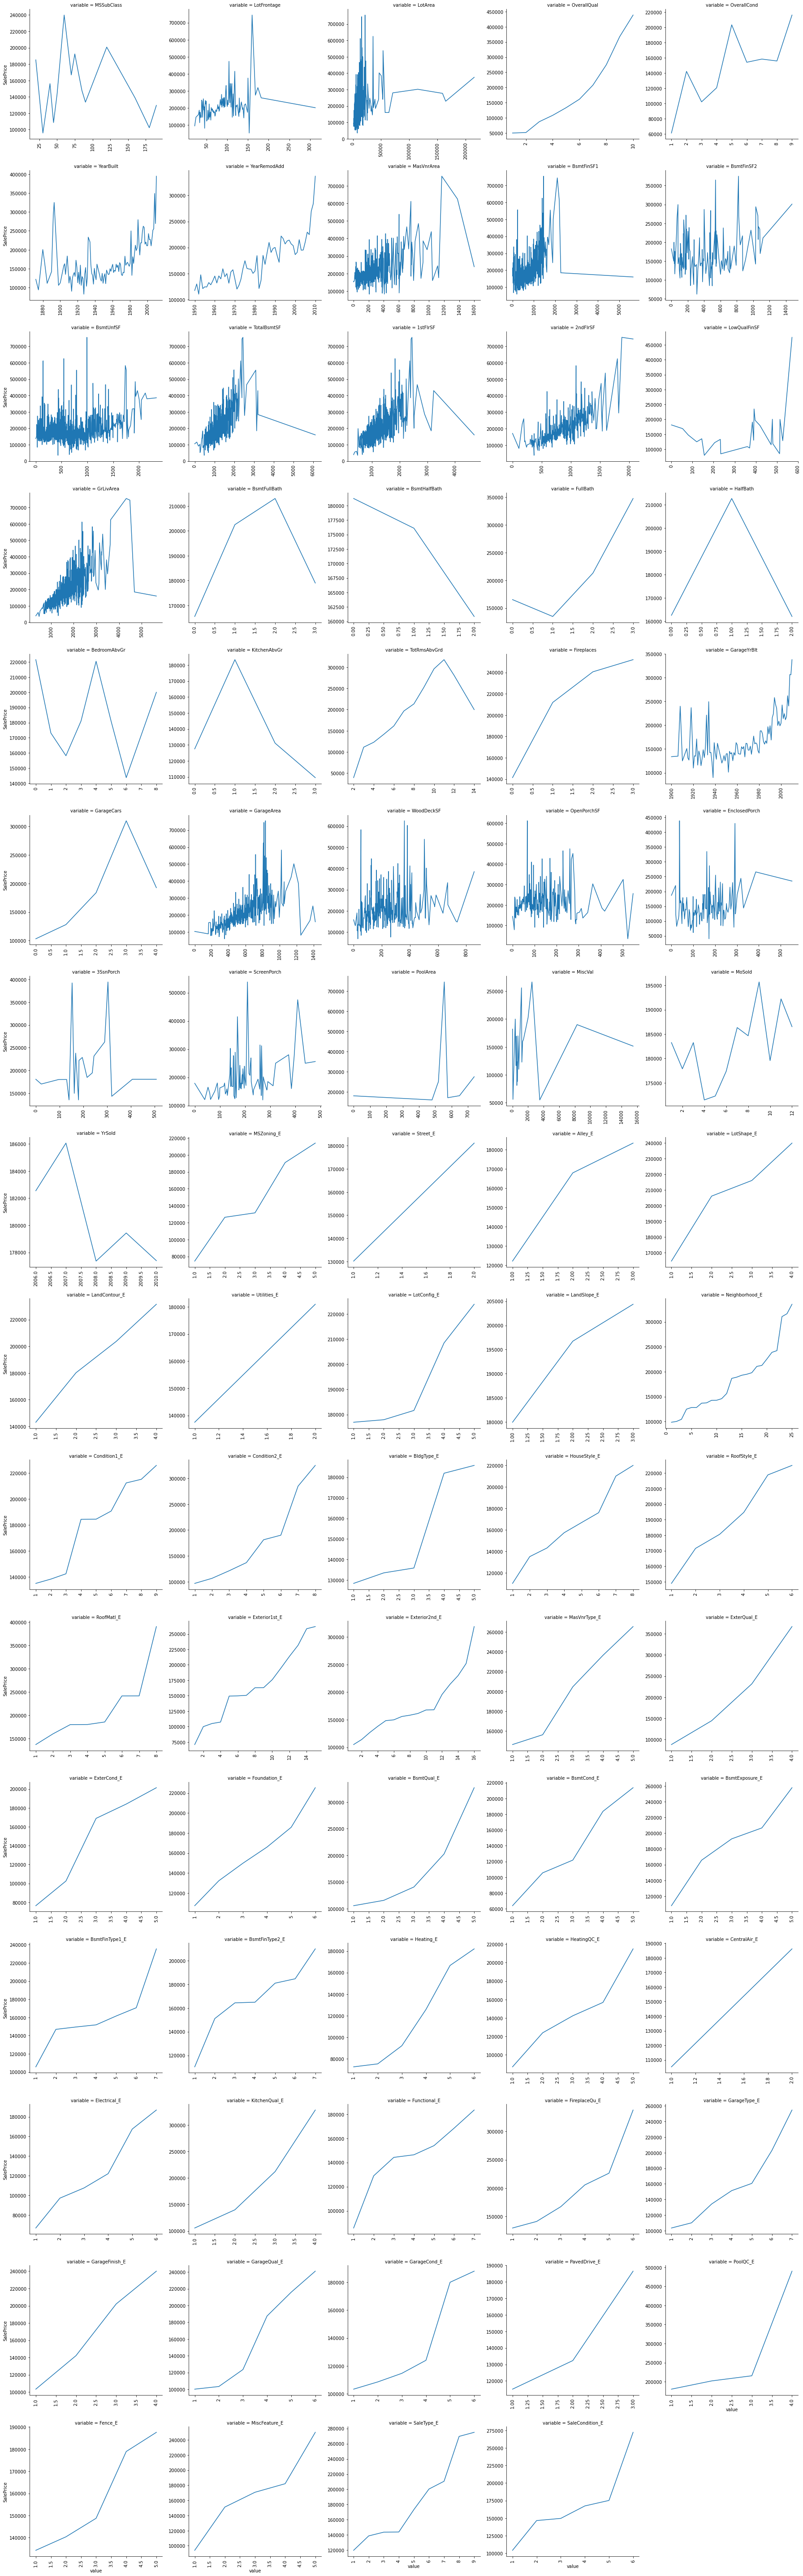

In [17]:
def pairplot(x , y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax= ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars =['SalePrice'], value_vars = quantitative + qual_encoded)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5, sharex = False, sharey = False, size =5)
g = g.map(pairplot, 'value', 'SalePrice')

For some variables, there is no linearity towards the sale price and it wont be selected by Lasso/ Lars. Some factors like Year Built, 1stFlrSF would benefit from adding quafratic term to regression. It will also provoke overfit as well. The pattern that we can observed is that it got a fluctuation in narrow range of variable towards the saleprice. That means it may not be able to be explained by using the simple linear function.

##### Price Segments

Try to form some group with a price cutoff to check with the position different for some parameters.

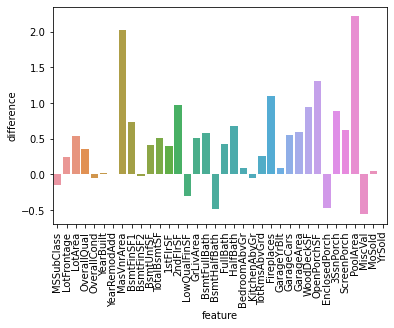

In [18]:
features = quantitative
# Using 200000 as a cutoff for standard and pricey group
standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

# Create an empty data frame
diff = pd.DataFrame()
diff['feature'] = features
# Calculate the mean for each group and calculate the differnet portion
diff['difference'] = [(pricey[f].fillna(0.).mean() - standard[f].fillna(0.).mean())/ (standard[f].fillna(0.).mean()) for f in features]
sns.barplot(data = diff, x = 'feature', y='difference')
x = plt.xticks(rotation = 90)

Try to divided the house price into two groups and compare the mean variables. The cutoff can be adjusted as well to give different information. 

In [19]:
diff.sort_values('difference')

,feature,difference
33,MiscVal,-0.559517
17,BsmtHalfBath,-0.487756
29,EnclosedPorch,-0.479096
14,LowQualFinSF,-0.298300
0,MSSubClass,-0.150366
21,KitchenAbvGr,-0.050115
4,OverallCond,-0.047635
9,BsmtFinSF2,-0.023328
35,YrSold,-0.000021
6,YearRemodAdd,0.010197


There is a big difference for PoolArea, MasVnrArea and OpenPorchSf in expensive house and it can be a critical parameters for the determination of House Price.

##### Clustering

In this part, t-SNE and PCA was used to reduct the dimension for the data and we can try to obtain those information and represent it as a 2D-Axis Plot and find out some cluster for further investigation

0.7499496239526735


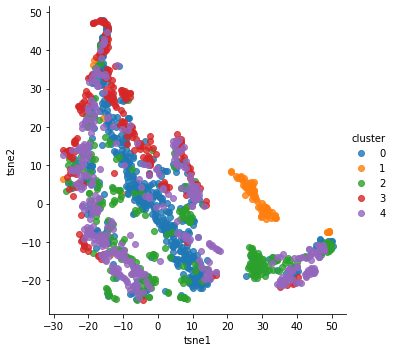

In [20]:
features = quantitative + qual_encoded
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

Need some time to understand this part since it combined t-SNE, PCA and Kmean for clustering. It used tsne to represent the axis but the explained_variance_ratio was come from the PCA. I will try to use a normal PCA to check with the result. We can come back to here later.

In [21]:
X2 = train[features].fillna(0.)

In [22]:
# First, standardise those parameters instead of the price
from sklearn.preprocessing import scale
standardisedX = scale(X2)
standardisedX = pd.DataFrame(standardisedX, index = X2.index, columns = X2.columns)

In [23]:
# After standardisation, all the standard deviation was changed to 1
standardisedX.apply(np.std)

MSSubClass         1.0
LotFrontage        1.0
LotArea            1.0
OverallQual        1.0
OverallCond        1.0
                  ... 
PoolQC_E           1.0
Fence_E            1.0
MiscFeature_E      1.0
SaleType_E         1.0
SaleCondition_E    1.0
Length: 79, dtype: float64

In [24]:
# Try to find out all principle components needed for obtain 95% of explained_variance
pca = PCA(n_components= 0.95)
pca.fit(standardisedX)

PCA(n_components=0.95)

In [25]:
np.round(pca.explained_variance_ratio_,2)

array([0.18, 0.05, 0.05, 0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.  , 0.  ])

In [26]:
len(pca.explained_variance_ratio_)

57

There is 57 PC components for getting 95% of explained variance but the explain variance for the first and second PC is too low since it just have 23% and that's why the editor will use tsne to represent the compressed information.

In [27]:
pca.explained_variance_ratio_[:30].sum()

0.7509728064437686

By adding up the first 30 components, it is around 75% of the explained variance. it is matched with the editor calculation.

The usage for KMean is that he would like to catagorise the house price into five different groups for clustering.

----------------

t-SNE is another tool that we can visualize high-dimensional data. Reading the documentation of sklearn, it helps to converts similarities between data points to joint probabilities and tries to minimize the Kullback-leibler divergence. It got a cost function and we can have different result if we start it at different initializations. TruncatedSVD is suggested for sparse data. 

In [28]:
# building a model for TSNE
# n_components: dimension of the embedded space (2 is suggested for clustering in two dimensions)
# random_state: ensure the reproducible result and different initialization might result in different local minima
# for the cost function
# perplexity: related to the number of nearest neighbors used for manifold learning. Large dataset with large perplexity
# Try to pick it within 5 to 50.
model = TSNE(n_components = 2, random_state = 0, perplexity = 50)

In [29]:
# fill the missing value since tsne is not avaliable for missing value
# fit the data into the model
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

0.7494018472566213


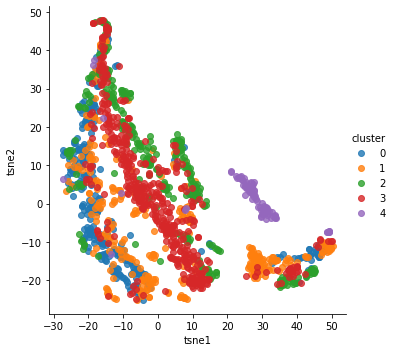

In [30]:
# PCA is used to reduce the dimension and get ready for K-means
# K-means is used to find out the closest group and classify as the same group
# Then, it can be used as the classes for clustering in the embedded t-SNE dimensions

# Standardise the data is important before applying to PCA
std = StandardScaler()
s = std.fit_transform(X)
# Set the maximum n_components/ PCs in 30, it can be more if it is looking for high explained variance
# that represent more data in more principal components
# or try to set a percentage for n_components and it will accumate the PCs and achieve the target explained variance
pca = PCA(n_components=30)
pca.fit(s)
# Call the transform function to do the projection
pc = pca.transform(s)
# Using K-means with the reduced data and form 5 clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

# Using the data reduced in t-SNE and display it with the class that clustered by k-means
fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
# Get the explained variance ratio to know how the PCA components represent the original data
print(np.sum(pca.explained_variance_ratio_))

0.7499045387649768


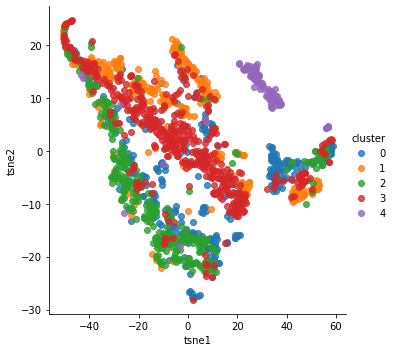

In [31]:
# Will it be a big different if we change the random state
model = TSNE(n_components=2, random_state=10, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
print(np.sum(pca.explained_variance_ratio_))

Those point is plotted in different location if we change the random_state which is another starting point.

How about plot it directly with PCA? Let's try it.

0.2261359418299434


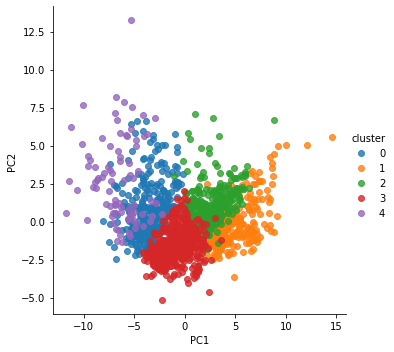

In [32]:
df_pca = pd.DataFrame({'PC1' : pc[:,0], 'PC2' : pc[:,1], 'cluster': kmeans.labels_})
sns.lmplot(data = df_pca, x ='PC1', y = 'PC2', hue = 'cluster', fit_reg = False)
print(np.sum(pca.explained_variance_ratio_[0:2]))

As you can see, the sum of explained variance for the first two components is just only 22.6%. The error between the projected point & original point is very high. Comparing with the previous plot, the clusers was formed according to the K-means result. Also, the cluster was formed according to PC1 and we can try to dive into the coefficient of PC1. Let's try to investigate it and check out any out-standing feature.

In [33]:
# Get all the coefficient in different components & assign it to correlated feature
pc1 = np.array(pca.components_)
df_pc1 = pd.DataFrame(data = pc1, columns = train[features].fillna(0.).columns[0:])
df_pc1.index = [f"PC{c}" for c in range(1,31)]

In [34]:
# Sort the values and check with the biggest
df_pc1.iloc[0].sort_values().tail()

ExterQual_E       0.204677
GarageCars        0.204982
YearBuilt         0.209178
Neighborhood_E    0.209629
OverallQual       0.222157
Name: PC1, dtype: float64

As we can see that, the OverallQual, Neighborhood, YearBuilt, GarageCars and ExterQual_E was the top five features that correspon to PC1 clustering. It is quite similar to previous investigation. Although the explained variance is low, we can still find some cluster comparing to TSNE clustering. One downside is that the coefficient is not that out-standing, we may not find a critical parameters or many parameters will affect the House price.

We can see that just using PCA with K-means will be better by using TSNE + PCA & K-means in these data set. It means that there is no perfect model for dimension reduction. Let's investigate more in another note book and we can still focus on the house price data set now.

##### Regression

In the notebook, editor try to build some linear model such as LassoLarsCV & RidgeCV and fit with those feature data and get the error. Within the progress, he tried to transform those feature data with log & quafratic function according to the previous data analysis.

He didn't talk about it much and I think it is a great time for us to understand more by searching how those models works.

First, he tried to defined some functions for data transformation.

In [35]:
def log_transform(feature):
    # replace the feature data in train dataframe and transform it by log the values
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    # create a new function with new column by square the value for that feature
    train[feature+'2'] = train[feature]**2

After that, he had applied these transformation for a bunch of data feature. I think it is important to check the reason why the editor transform those data by using these function. We can visualise it to check & some of it was explained by checking the pair plot without linear function. It tried to use quadratic function to transform it and fit into the model.

In [36]:
# list the feature for log transformation by the editor
log_list = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF','LotArea', 'LotFrontage', 'KitchenAbvGr','GarageArea']
# list the feature for quadratic transformation by the editor
quadra_list =['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '2ndFlrSF', 'Neighborhood_E','RoofMatl_E','GrLivArea']

We can try to display these feature with SalePrice in some way to observe any similarity that why the editor will transform it in this way.

Also, 'GrLivArea', '2ndFlrSF' and 'TotalBsmtSF' was appeared in both log transformation & quadratic transformation.

#### Log

The purpose for log transformation is that we can turn the data as normal as possible for the distribution. It aimed to reduce the skewness for the data.

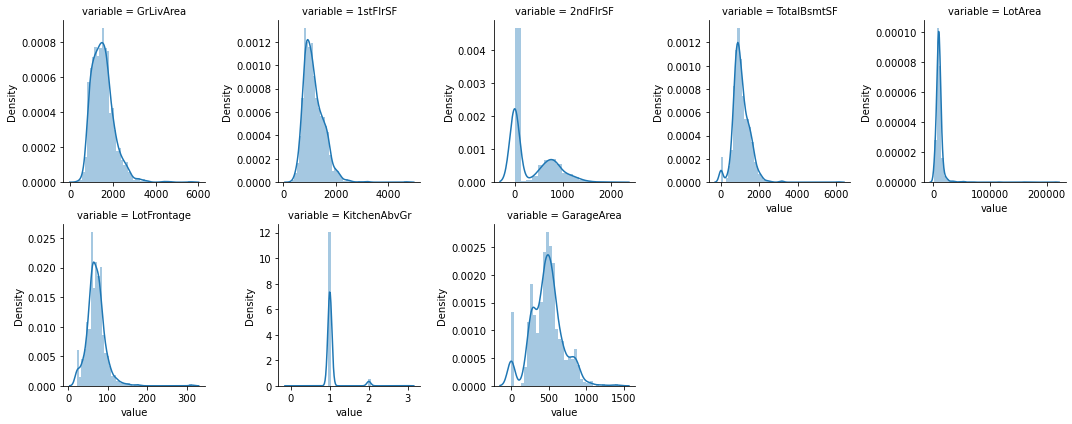

In [37]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=log_list)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

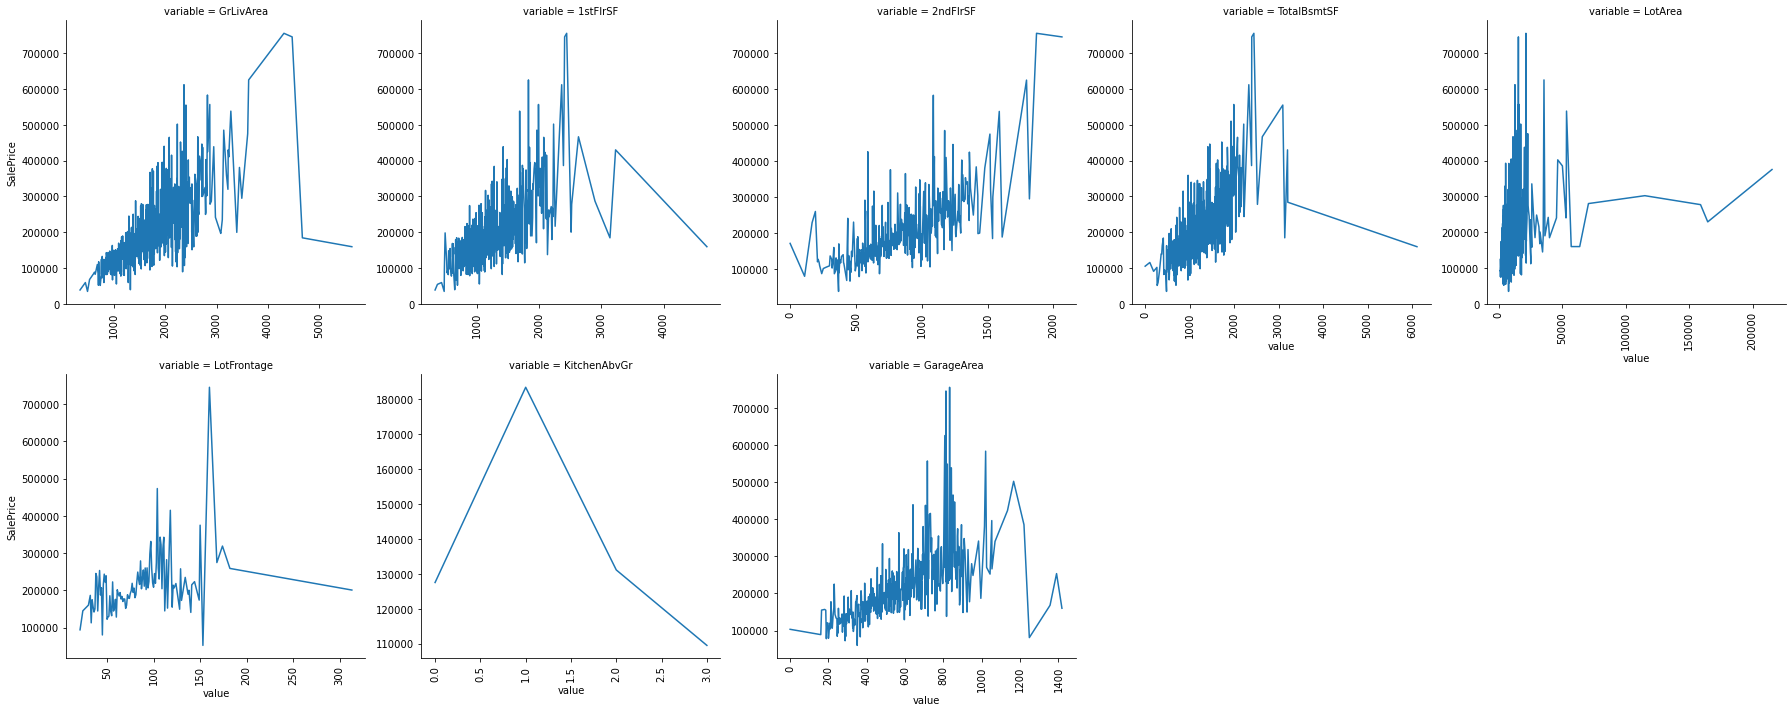

In [38]:
# display the pairplot for the features that needed to be log
def pairplot(x , y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax= ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars =['SalePrice'], value_vars = log_list)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5, sharex = False, sharey = False, size =5)
g = g.map(pairplot, 'value', 'SalePrice')

We can see that the features editor listed out was skew and we can visualise again once we finished the log transformation.

In [39]:
# perform the log transformation for selected features
for i in log_list:
    log_transform(i)

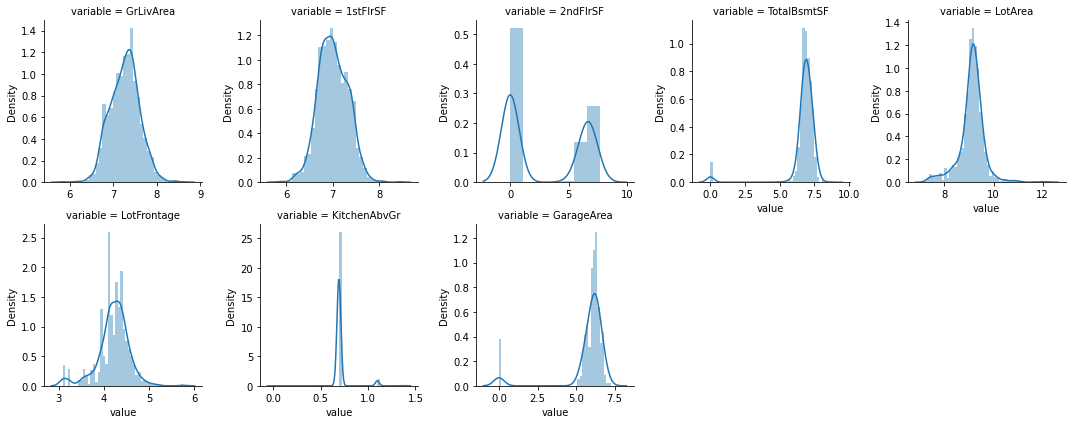

In [40]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=log_list)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

After log transformation, most of the data was changed into a bell shape distribution. We can also check the pair plot as below.

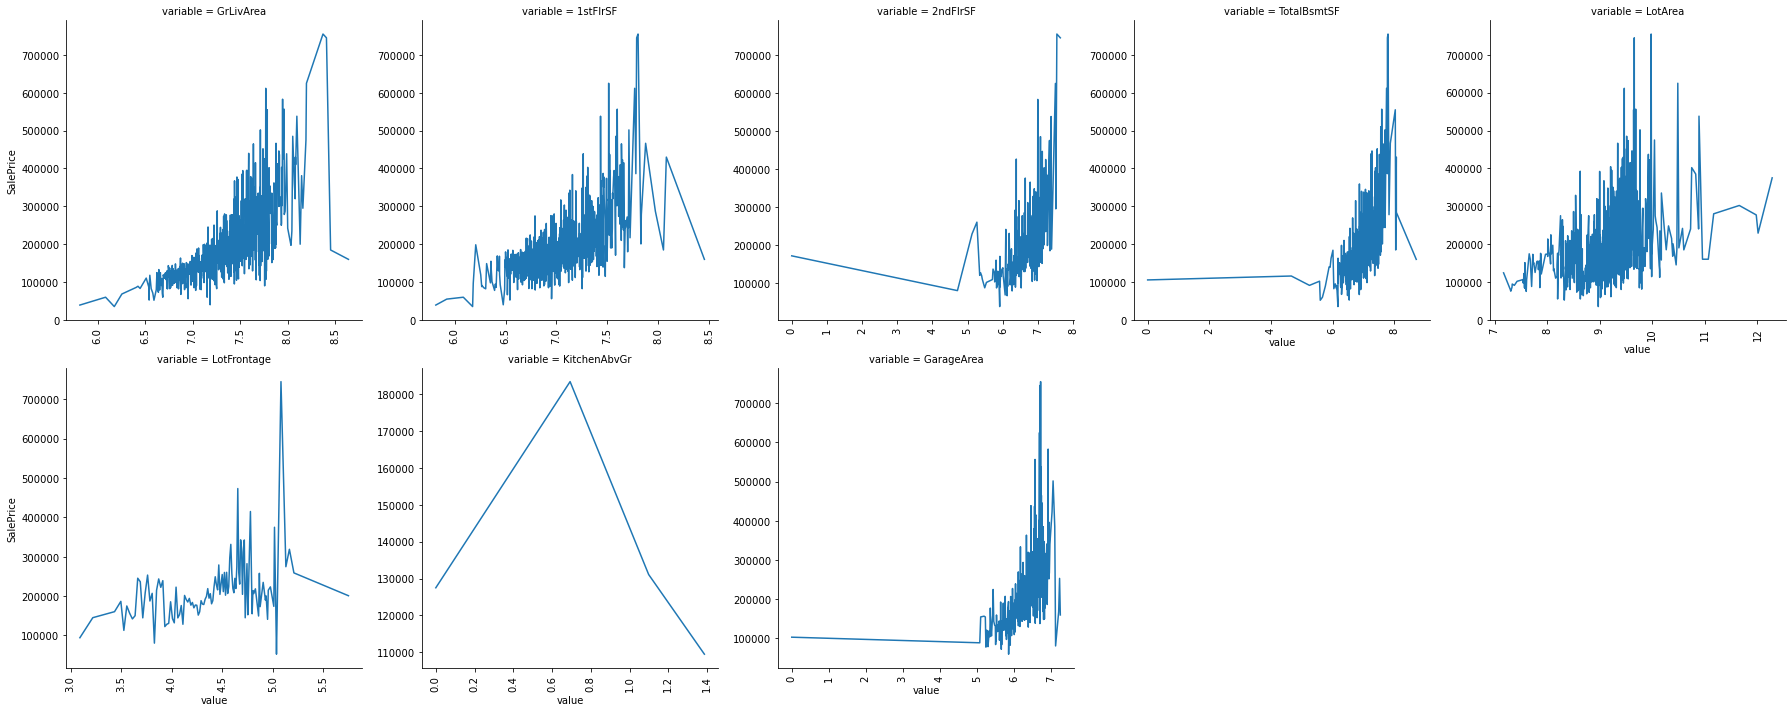

In [41]:
# display the pairplot for the features that needed to be log
def pairplot(x , y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax= ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars =['SalePrice'], value_vars = log_list)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5, sharex = False, sharey = False, size =5)
g = g.map(pairplot, 'value', 'SalePrice')

Also, the pair plot show that the fuctuation of frequency was compressed or pushed towards right. It means that the log transformation was not helpful to fix it. We can visualise again once we finished the quadratic transformation.

#### Quadratic

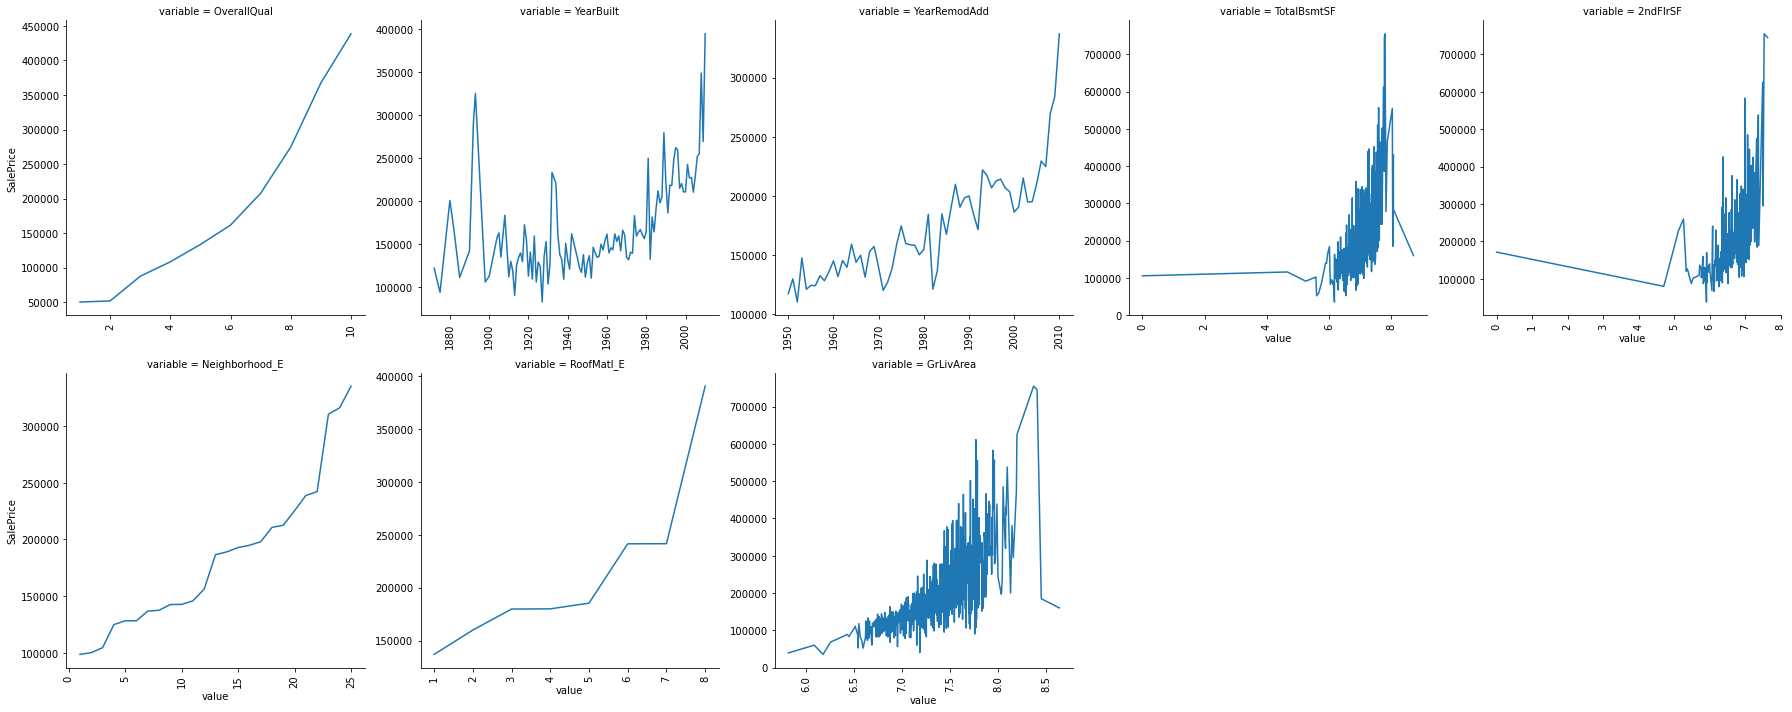

In [42]:
# display the pairplot for the features that needed to be quadratic
def pairplot(x , y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax= ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars =['SalePrice'], value_vars = quadra_list)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5, sharex = False, sharey = False, size =5)
g = g.map(pairplot, 'value', 'SalePrice')

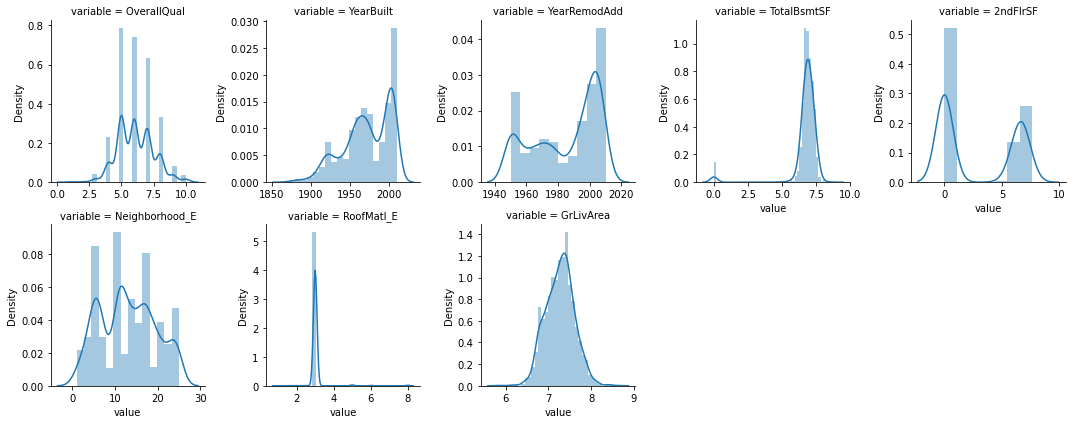

In [43]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=quadra_list)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Let's work on the quafratic transformation and check for the distribution.

In [44]:
for i in quadra_list:
    quadra_ed_list = quadratic(i)

In [45]:
quadra_ed_list = []
for i in quadra_list:
    quadra_ed_list.append(i+'2')

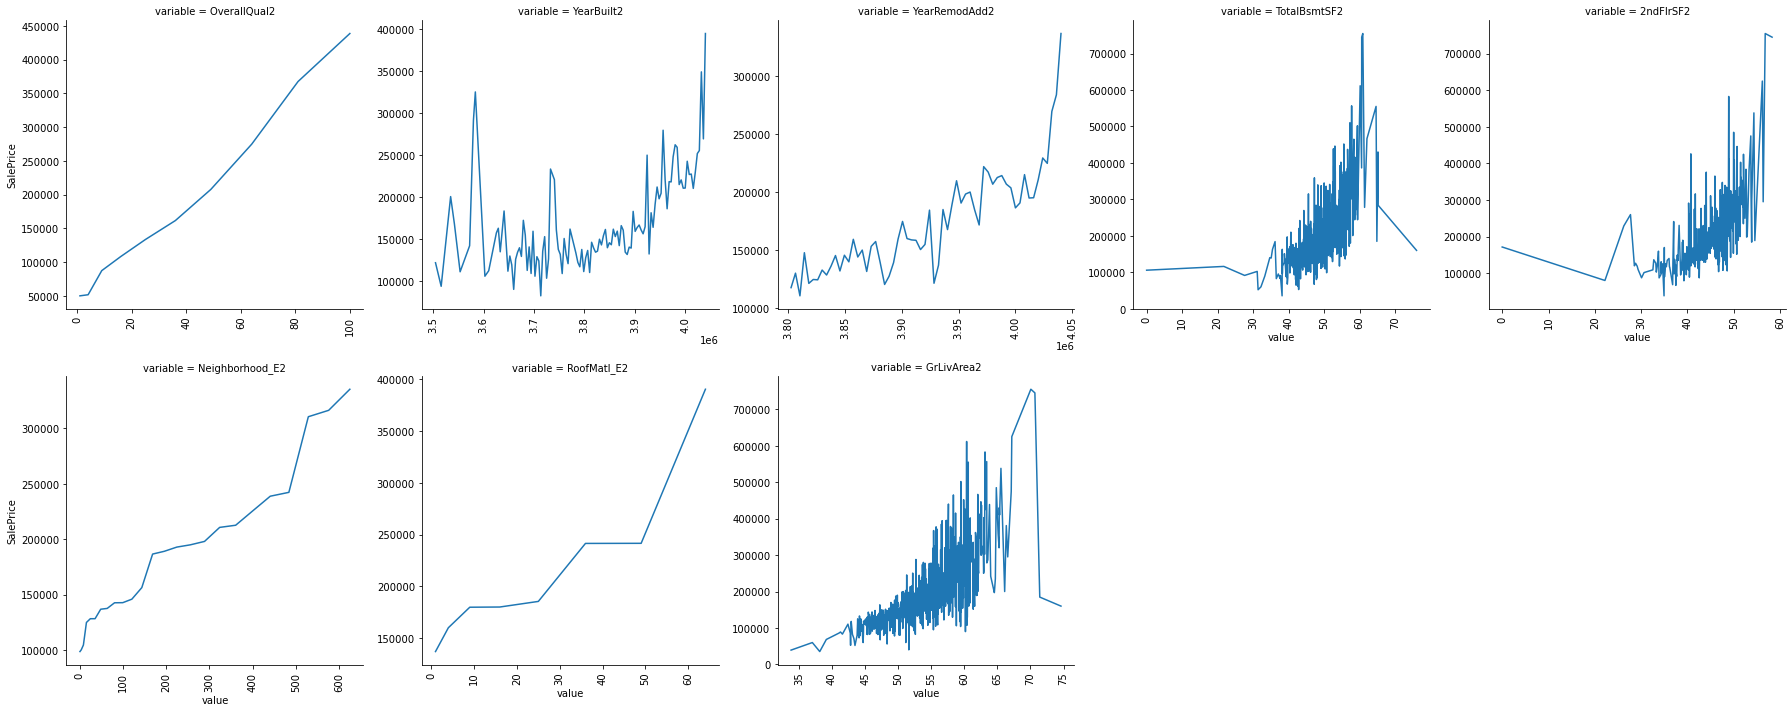

In [46]:
# display the pairplot for the features that needed to be quadratic
def pairplot(x , y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax= ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars =['SalePrice'], value_vars = quadra_ed_list)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5, sharex = False, sharey = False, size =5)
g = g.map(pairplot, 'value', 'SalePrice')

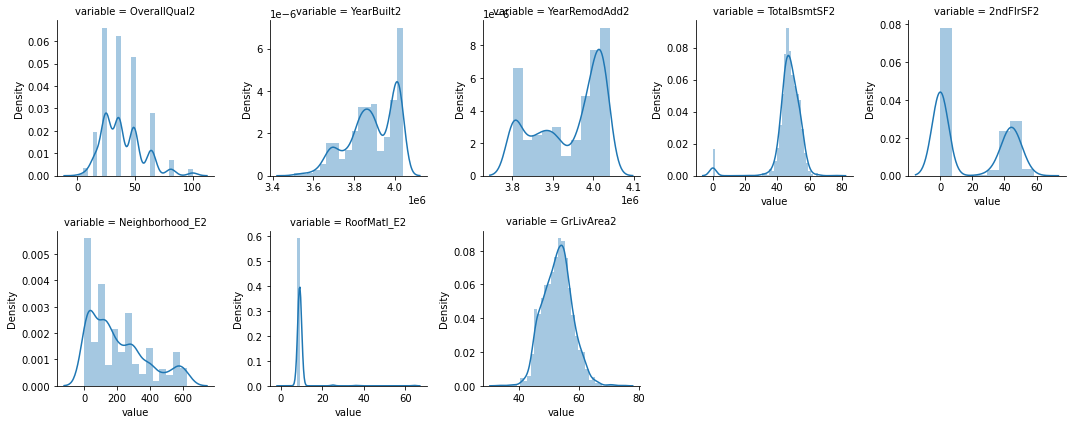

In [47]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=quadra_ed_list)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

After the quadratic transformation, it seems nothing changed. I am not sure the purpose for using the quadratic transformation but editor have created another column to store the quatratic value instead of replacement of log transformation. Therefore, quadratic transformation may not be useful. We can compare it by performing two different set of features with the error.

#### Boolean transformation

Not just log/ quadratic transformation. Editor has also create some column for some boolean features.

In [48]:
# new boolean feature
boolean_list = ['TotalBsmtSF','GarageArea','2ndFlrSF','MasVnrArea','WoodDeckSF','OpenPorchSF','PoolArea','YearBuilt']

Let's vistualise it again to check with the relation with saleprice & the distribution/

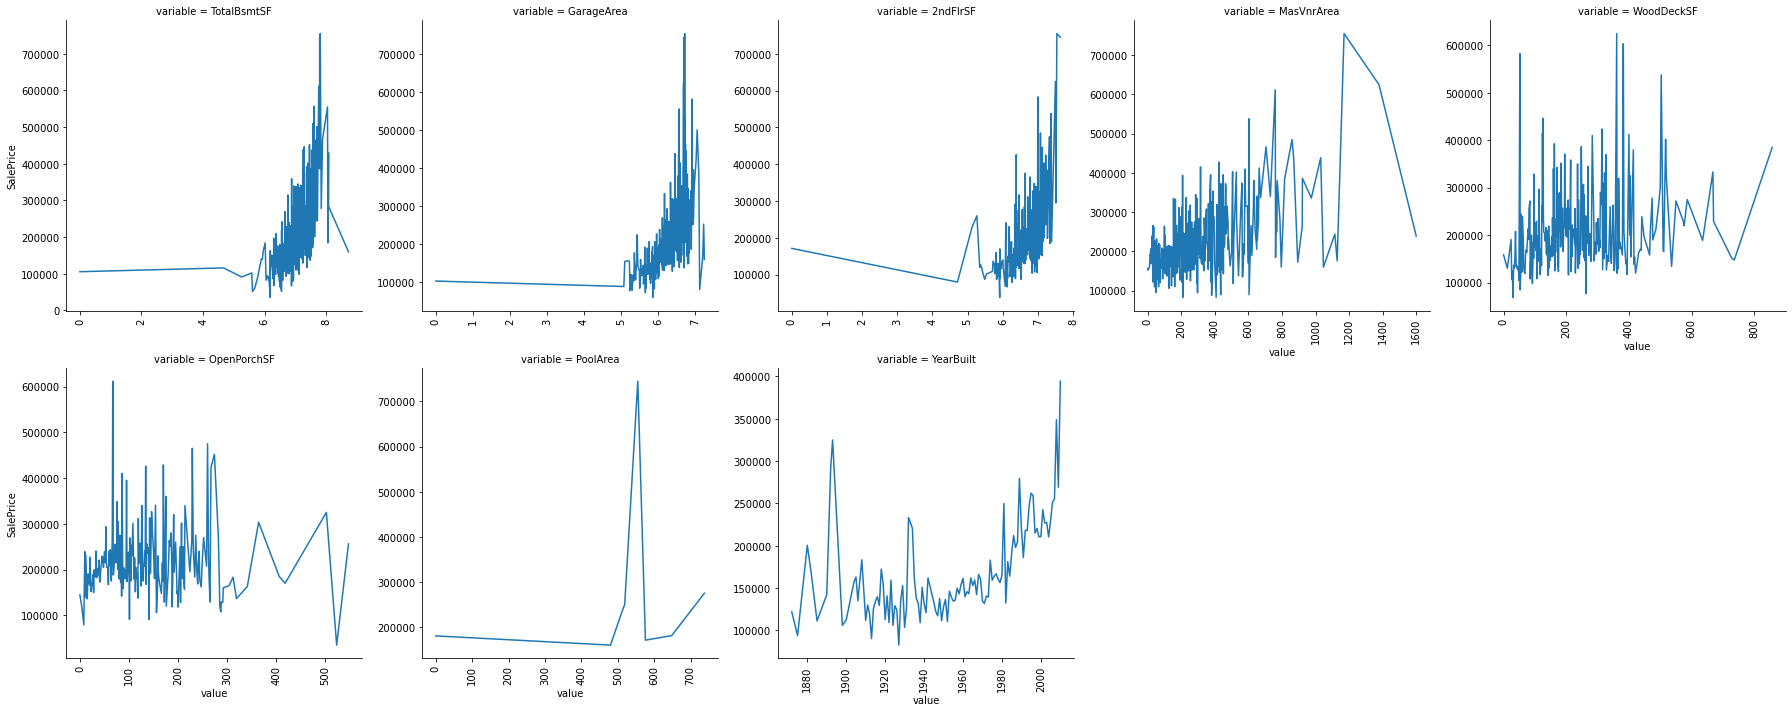

In [49]:
# display the pairplot for the features that needed to be quadratic
def pairplot(x , y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val':y})
    ts = ts.groupby('time').mean()
    ts.plot(ax= ax)
    plt.xticks(rotation = 90)

f = pd.melt(train, id_vars =['SalePrice'], value_vars = boolean_list)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 5, sharex = False, sharey = False, size =5)
g = g.map(pairplot, 'value', 'SalePrice')

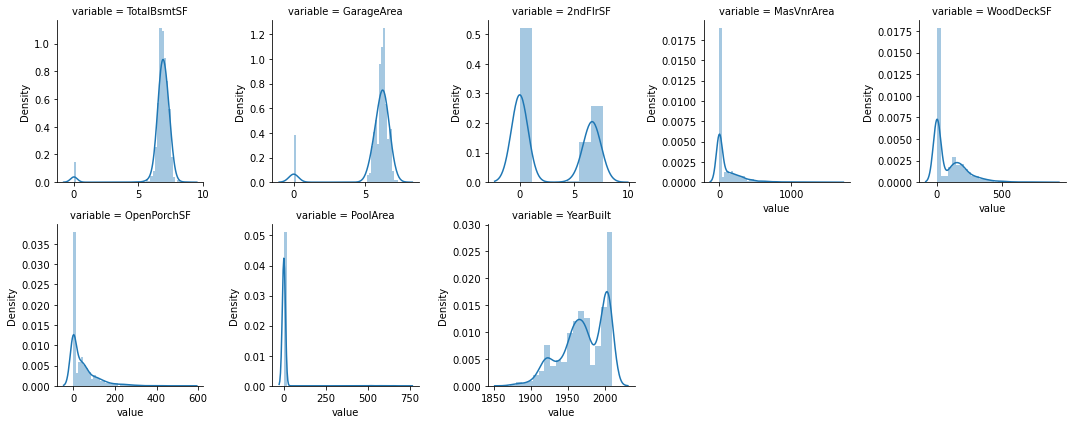

In [50]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=boolean_list)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

It is more reasonable for these feature having the boolean transformation. Most of the feature got multiple distribution and chaotic frequency with sale price. I think it is a good way to generate another column with two varibles only to get the relation with saleprice.

In [51]:
# generate a new boolean column for each feature
train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck','HasPorch', 'HasPool', 'IsNew']

Let's seperate two set of feature and work on the linear regression to compare the error

In [52]:
features = quantitative + qual_encoded + boolean
features2 = quantitative + qual_encoded + boolean + quadra_ed_list

#### Without quadratic features

In [53]:
# define the error function to check with the performance
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual - predicted))/len(actual))

In [54]:
# create the model for linear regression
lasso = linear_model.LassoLarsCV(max_iter = 10000)
# select all the features and fill with 0 for null values
X = train[features].fillna(0.).values
# select the target for prediction
Y = train['SalePrice'].values
# fit the feature values and log sale price (make it more normal shape for distribution)
lasso.fit(X,np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y,Ypred)

0.11294469497953542

#### With quadratic features

In [55]:
# repeat it with quadratic features
# create the model for linear regression
lasso = linear_model.LassoLarsCV(max_iter = 10000)
# select all the features and fill with 0 for null values
X = train[features2].fillna(0.).values
# select the target for prediction
Y = train['SalePrice'].values
# fit the feature values and log sale price (make it more normal shape for distribution)
lasso.fit(X,np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y,Ypred)

0.11194749395516343

To compare the error, it is just around 0.1% different. By doing the quadratic transformation in editor way, it doesn't give a lot improvement for the error. Therefore, it may not be necessary to perform quadratic information for those feature.

How about adding the boolean features? Let's have a check!

In [56]:
# define the features be fitted in the model
features = quantitative + qual_encoded

#### Without boolean features

In [57]:
# create the model for linear regression
lasso = linear_model.LassoLarsCV(max_iter = 10000)
# select all the features and fill with 0 for null values
X = train[features].fillna(0.).values
# select the target for prediction
Y = train['SalePrice'].values
# fit the feature values and log sale price (make it more normal shape for distribution)
lasso.fit(X,np.log(Y))

Ypred = np.exp(lasso.predict(X))
error(Y,Ypred)

0.12177296913715306

Now, the error was increase with ~1%. It means that the boolean column do give some effect towards the model performance but it is not that significant.

#### Pasty

Another regression, editor used Pasty library to deal with the data transformation. Let's dive into it to learn more.

It started with a function called dmatrices.

In [58]:
import patsy

Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

dmatrices which is called designed matrices. Within the matrices, it got a lot different attribute and we have to go through one by one. It didn't select all the features but just the feature with high correlation with out target Saleprice.

bs -> Turn the data into B-spline basis. 

bs(X, df(degree of freedom), degree(degree of the spline to use))

Q -> use to quote the variable name do not meet Python's variable name rules.

In [59]:
# let visualise some features that was transfromed into b-spline basis to know why it needed to be transformed
bs_list = ['OverallCond','MSSubClass','LotArea','FullBath','HalfBath','BsmtFullBath']

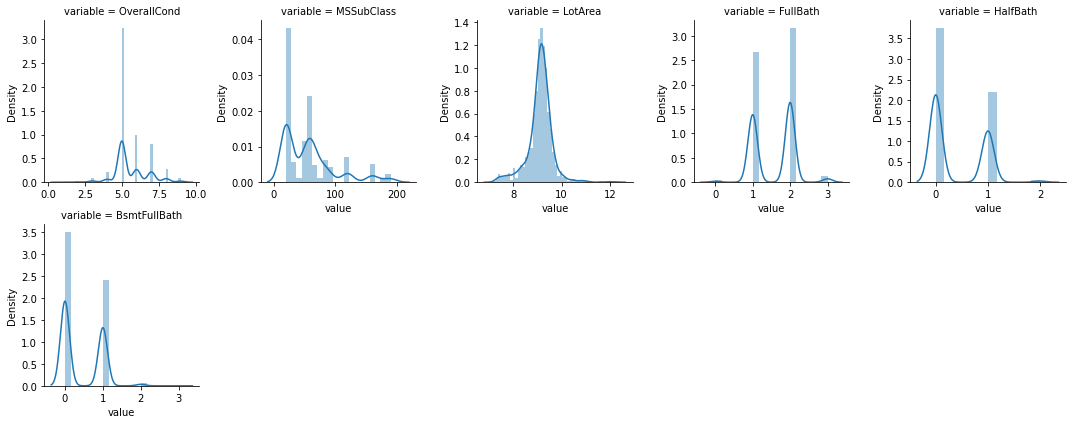

In [60]:
# Generate the distplot for each variable to check the distribution
f = pd.melt(train, value_vars=bs_list)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

By checking these distribution, we can see that there is few distributions for these data set. Editor tried to use quadratic transformation but it is not useful for performance improvement. Therefore, turn it into b-spline basis may be useful at all.

In [61]:
# create a RidgeCV model and fit the data transformed by patsy
ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))
Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

0.11602320727290605


By just select with few important features, we can obtain similar error. Therefore, it means that some of the features was not that useful and we can ignore it.

This is the end of the editor code. It is going to investigate more about the linear model and we can have more understanding of using those model.

### Linear model

#### LassoLarsCV(L1) & RidgeCV(L2)

Reference:

StatQuest Time!

1) https://www.youtube.com/watch?v=Q81RR3yKn30

#### Ridge Regression: (Continuous variable)

Stragint line with least square redisual + lambda * the slope^2 (penalty to the traditional least squares method)

- lambda determine the penalty

Without the small amount of bias, least squares method got large amount of variance.

Ridge Regression Line, has the small amount of Bias due to the penalty with less variance.

Ridge Regression penalty resulted in a line with smaller slope -> less sensitive to X variable than least square line.

Lambda - can be every value and only minimize the sum of squared residuals

Larger the lambda -> slope is close to 0 -> less sensitive to X variable

What lambda should use? -> 10-fold Cross validation to try a bunch of lambda.

#### Ridge Regression: (Discrete variables - Normal Diet vs High Fat Diet)

minimize the sum of the square residuals + lambda * Diet Difference^2

lambda get larger -> prediction for the size on high fat diet becomes less sensitive to the difference between the normal diet & the high fat diet (Ridge regression can help with reduce the big difference of small sample size data)

Logistic regression:

Is obese = y-intercept + slope * Weight

- optimize the sum of likelihoods but not the squared residuals

the sum of the likelihoods + lambda * slope^2

First main function:

Reduce the variance by shrinking parameters & making our predictions less sensitive to them

Applicable to complex models as well, try to make less sensitive to all parameters except for the y-intercept       

#### Ridge Regression for less data point

Two data point is needed for least square equation

Three parameter:

Just two data point is not enough -> needed to fit a plane instead of a line

Need much data point for more parameters

10000 data points is needed fo 10000 genes as parameters

adding the ridge regression penalty -> just need 500 or fewer sample

2) https://www.youtube.com/watch?v=NGf0voTMlcs

#### Lasso Regression (L1)

Very similar to Ridge Regression but it has some very important differences

##### Similar

Instead of square of slope, absolute slope was used with lambda -> Lasso Regression

the sum of the squared residuals + lambda * |the slope|

Another line with a little bit of bias & less variance than least square

Make prediction of size less sensitive to tiny training dataset

Contain all the estimated parameters except the y-intercept

##### Big Difference

When lambda = 0, Lasso Regression is the same as least squares line

When lambda increase, slope get smaller until slope get zero

Ridge regression can only shrink the slope asymptotically close to zero

Lasso regression can shrink the slope all thw way to zero

Ridge regression can shrink some non-related parameter a lot but never be equal to 0

Lasso regression can shring some realted parameter a little bit and non-related parameter can go to zero and those non-related parameter will go away

Ridge regression is better when most of the variable is useful.

That's the reason why editor use lasso regression with all the features & ridge regression for selected features.

#### Another regularization technique - Elastic-Net Regression

Just found another regularization method and it is great to take a look on it at the same time.

https://www.youtube.com/watch?v=1dKRdX9bfIo

Lasso regression will keep the useful parameter and eliminate the useless parameter.

Ridge regression will shrink all the parameter but not remove them.

What should we do if the model include tons more variable?

Those variables might be useful or useless. Elastic-Net Regression will be a good choice.

#### Elastic-Net Regression started with least squares rediduals

It combine the Lasso Regression Penalty -> lambda1 x |v1|+...+|vx|
                                              +
& the Ridge Regression Penalty -> lambda2 x v1^2 + vx^2

Cross Validation on different combination of lambda1 & lambda2 to find the best values

Hybrid of two regressions ->good to deal with correlation between parameters

Lasso Regression will take one correlated term and eliminate the other

& Ridge Regression will shrink all the variables together once.